# main

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math

In [2]:
import metalabeller as ml

In [3]:
df = dl.get_working_data("BTCUSDT")

In [19]:
a = df.to_numpy()

In [28]:
ma = df.open.rolling(window=10000).mean().diff()

In [107]:
def find_pivots(df, unit = 1000):
    """returns timestamps of peaks"""
    i = 0
    price = df.open.to_list()
    timestamps = df.timestamp.to_list()
    h_ts = [] #high timestamps
    l_ts = []
    past = price[0]
    now = price[0]
    future = price[unit]
    while True:
        if now>past and now>future:
            h_ts.append(timestamps[i])
        elif now<past and now<future:
            l_ts.append(timestamps[i])
        i += unit
        past = now
        now = future
        try:
            future = price[i+unit]
        except:
            break
    return h_ts, l_ts
                

In [112]:
h, l = find_pivots(df)

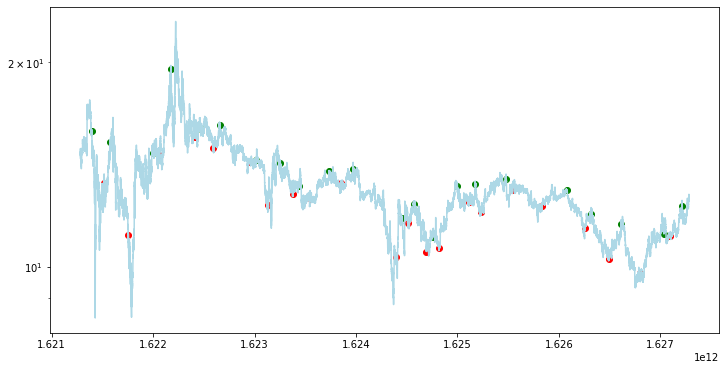

In [113]:

fig, ax = plt.subplots(figsize=(12, 6))
plotdf = df[-200000:-100000]
h = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, h))
l = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, l))

plt.yscale("log")
ax.plot(plotdf.set_index("timestamp").open, c="lightblue")
ax.scatter(h, plotdf.set_index("timestamp").reindex(h)["open"], c="green")
ax.scatter(l, plotdf.set_index("timestamp").reindex(l)["open"], c="red")

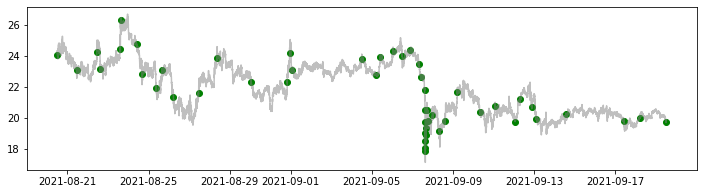

In [8]:
t_range = t_events[-100:-50]
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(t_range, df.reindex(t_range).open, c="green")
ax.plot(df[(df.index>t_range[0]) & (df.index<t_range[-1])].open, c="gray", alpha=0.5)

In [4]:
vol = ml.get_daily_vol(df.open)
t_events = ml.get_t_events(df.open, vol, 0.02)
t1 = ml.get_vertical_barrier(df.open, t_events, 2)

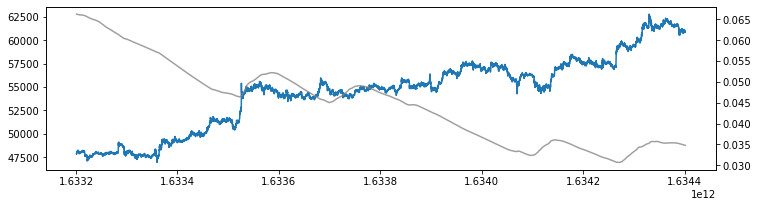

In [5]:
a = [-20000, -1]
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df.open[a[0]:a[1]])
ax1 = ax.twinx()
ax1.plot(vol[a[0]:a[1]], c="gray", alpha=0.75)

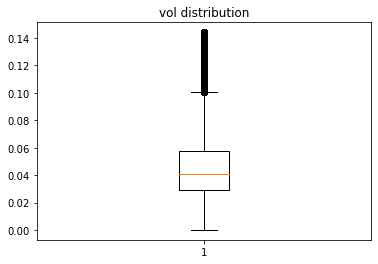

In [6]:
fig, ax = plt.subplots()
ax.set_title('vol distribution')
ax.boxplot(list(vol.dropna()))
plt.show()

In [7]:
side = pd.Series(np.random.randint(0, 2, len(t_events)), index=t_events)

In [8]:
ind = list(t1.index)
val = list(t1)
new = []
for i in range(len(ind)):
    new.append(val[i]-ind[i])

<AxesSubplot:>

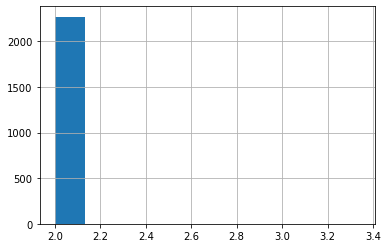

In [10]:
a = t1.index.values
new = (t1.loc[a]-a)/(60000*24*60)
new.hist()

In [11]:
# create target series
ptsl = [1,1]
min_ret = 0.00
    
events = ml.get_events(df.open,t_events,ptsl,vol,min_ret,1,t1=t1,side=side)
events

,t1,trgt,side
1503117360000,1503117720000,0.006933,1.0
1503117780000,1503290580000,0.010779,0.0
1503118620000,1503291420000,0.010732,0.0
1503120660000,1503293460000,0.011257,0.0
1503125820000,1503298620000,0.013560,0.0
...,...,...,...
1634058180000,1634230980000,0.033502,0.0
1634076060000,1634173440000,0.033255,1.0
1634110560000,1634283360000,0.033126,0.0
1634137680000,1634310480000,0.035898,0.0


<AxesSubplot:>

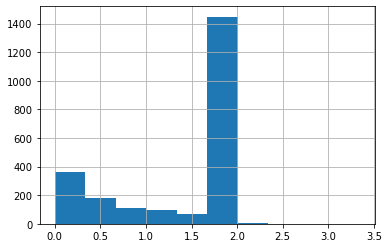

In [12]:
a = events.index.values
new = (events.loc[a].t1 - a)/(60000*24*60)
new.hist()

In [13]:
labels = ml.get_bins(events, df.open, t1)

In [14]:
labels

,ret,target
1503117360000,0.008544,1.0
1503117780000,-0.000000,0.0
1503118620000,0.000000,0.0
1503120660000,0.000000,0.0
1503125820000,-0.000000,0.0
...,...,...
1634058180000,0.000000,0.0
1634076060000,0.033957,1.0
1634110560000,0.000000,0.0
1634137680000,0.000000,0.0


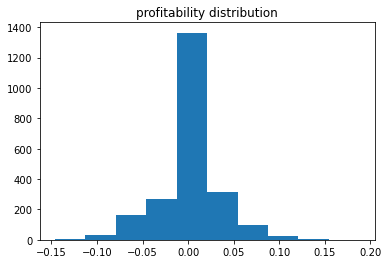

In [15]:
fig, ax = plt.subplots()
ax.set_title('profitability distribution')
ax.hist(labels.ret)
plt.show()

In [14]:
lookback = 4000
def get_z_score(a, b):
    """Returns the latest zscore between dataframes a and b. IF NAN, RETURN PREVIOUS"""
    a = a.set_index("timestamp") #Do not set inplace cause reference
    b = b.set_index("timestamp")

    df = pd.to_numeric(a.open.rename("A")).to_frame()
    df["B"] = pd.to_numeric(b.open)

    df.dropna(inplace=True)

    results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
    hr = results.params[1]
    spread = pd.Series((df['B'] - hr * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(lookback).mean()
    spread["std"] = spread.spread.rolling(lookback).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
    return get_non_nan_zscore(spread)    
    
def get_non_nan_zscore(spread):
    """loops through spread finding latest non-nan zscore"""
    zscore = spread.iloc[-1].zscore
    i = 2
    while math.isnan(zscore):
        zscore = spread.iloc[-i].zscore
        i += 1
    return zscore

In [10]:
a = dl.get_minutely_data("HNTUSDT", past=False)
b = dl.get_minutely_data("BTCUSDT", past=False)

In [17]:
z = get_z_score(a, b)

In [18]:
z

-0.15050287861225423